## Part 1: Load Libaries and Import necessary dataset

In [1]:
# Load required libraries. Make sure to install them too
library(readxl)
library(dplyr)
library(Rcpp)
library(ggplot2)
library(lubridate)
library(forecast)
library(prophet)
library(Metrics)
library(zoo) # use for date formatting 
library(stats) # use for additive



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: rlang


Attaching package: ‘Metrics’


The following object is masked from ‘package:rlang’:

    ll


The following object is masked from ‘package:forecast’:

    accuracy



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:

# Extract deposit_levels to use it in this file
deposit_levels <- readRDS("/workspaces/DUKE_MIDS_QFC_Final_Project/data_cleaning/deposit_levels.rds") # Load the data


In [3]:
glimpse(deposit_levels)

Rows: 162
Columns: 2
$ time     <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "1985Q2", "…
$ deposits <dbl> 22917257000, 23575192000, 24308965000, 24967964000, 256737460…


## Part 2: Data Exploration for Prophet Assumption

### Step 1: Data Regularity and Sufficient Historical Data Expectation

- **Purpose**: Prophet requires data to be regular (no gaps in time periods) and free of missing values to build accurate forecasts.

In [4]:
sum(is.na(deposit_levels))  # no missing values

[1] 0

- The time series has regular quaterly intervals and no missing values so the data regurlarity expectation is satified. 

- It also has decades worth of data so the "sufficient historical data" expectation is satisfied. 

### Step 2: Presence of Trend Expectation

- **Purpose**: Prophet models require a clear understanding of the trend to accurately forecast future values. 

- **Next Steps**: Evaluate whether the data exhibits a linear or logistic trend.

- **Question** Does the choice of a linear trend or logistic trend affect Prophet's predictions?

- **Answer** : Yes, it absolutely affects the predictions. Here’s how:

    - **Linear Trend**: Assumes that growth continues indefinitely at a constant rate.
        - Future predictions will show a strong upward trend, even if the data is slowing down.
        - Example: If you fit a linear trend to deposit levels, Prophet will extrapolate a steadily increasing deposit level far into the future.

    - **Logistic Trend**: Assumes growth slows as it approaches a saturation point. 
        - Future predictions will show a more tamed upward trend, leveling off over time.
        - Example: If deposits are approaching a plateau, a logistic trend will reflect that in future predictions, ensuring the model doesn't over-predict growth.

- **Key Insight**:If you fit Prophet with the wrong trend type (e.g., linear when the data shows signs of saturation), your forecasts will misrepresent the future. Context is critical here: If you know from domain expertise or external analysis that growth will saturate, using a logistic trend will give more realistic predictions.

#### a. Formatting the time as a date instead of a character and also have anumeric format of the date

In [5]:
# Step 1: Format time as date 
# Format
time <- as.Date(as.yearqtr(deposit_levels$time, format = "%YQ%q"))
# Add the formatted date back into the dataset
deposit_levels$time_as_date <- time

# Step 2: Format time as numeric
# Format
time2 <- as.numeric(deposit_levels$time_as_date)
#  Add the formatted date back into the dataset
deposit_levels$time_as_numeric <- time2

# Check
glimpse(deposit_levels)

Rows: 162
Columns: 4
$ time            <chr> "1984Q1", "1984Q2", "1984Q3", "1984Q4", "1985Q1", "198…
$ deposits        <dbl> 22917257000, 23575192000, 24308965000, 24967964000, 25…
$ time_as_date    <date> 1984-01-01, 1984-04-01, 1984-07-01, 1984-10-01, 1985-…
$ time_as_numeric <dbl> 5113, 5204, 5295, 5387, 5479, 5569, 5660, 5752, 5844, …


#### b. Visualizing Linear Trend

`geom_smooth()` using formula = 'y ~ x'


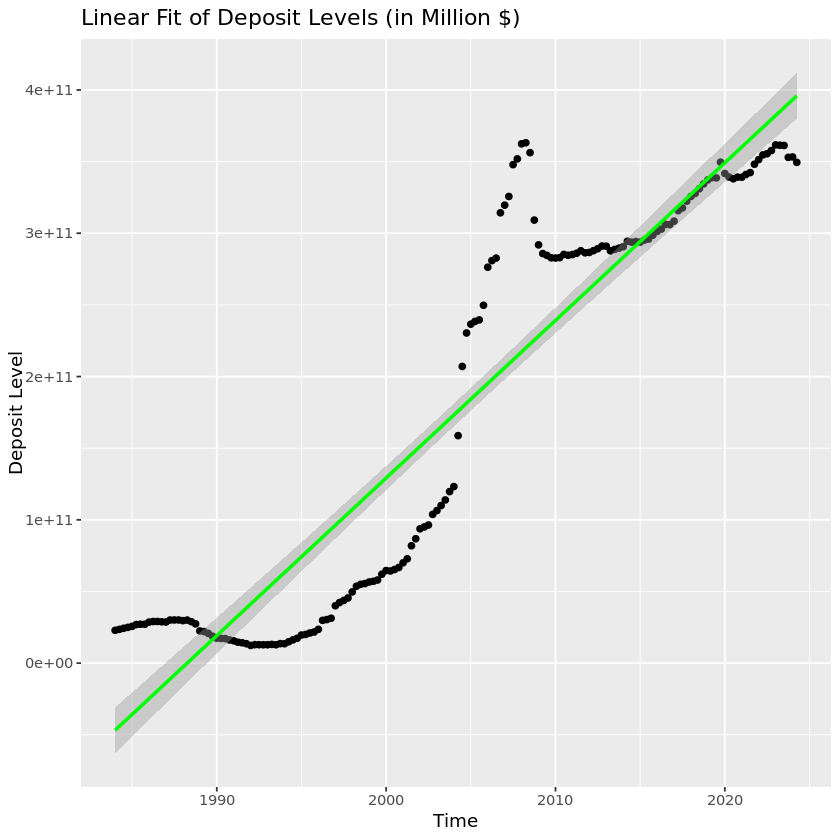

In [ ]:
# Step 1: Time needs to be formatted as numeric for it to work ==> DONE above

# Step 2: Fit the linear model
linear_model <- lm(deposits ~ time_as_numeric ,data = deposit_levels) # Use time as numeric here

# Step 3: Plot the linear model
ggplot(deposit_levels, aes(x=time_as_date, y=deposits)) + # Use time as date here
    geom_point() +
    geom_smooth(method = lm, col = "green") + # Adds a linear trend
    labs(title = "Linear Fit of Deposit Levels (in $)", x = "Time", y = "Deposit Level")

#### c. Visualizing Logistic Growth Trend

- Not the same as logistic resgression

- A mathematical model used to describe non-linear growth that slows as it approaches a saturation point.

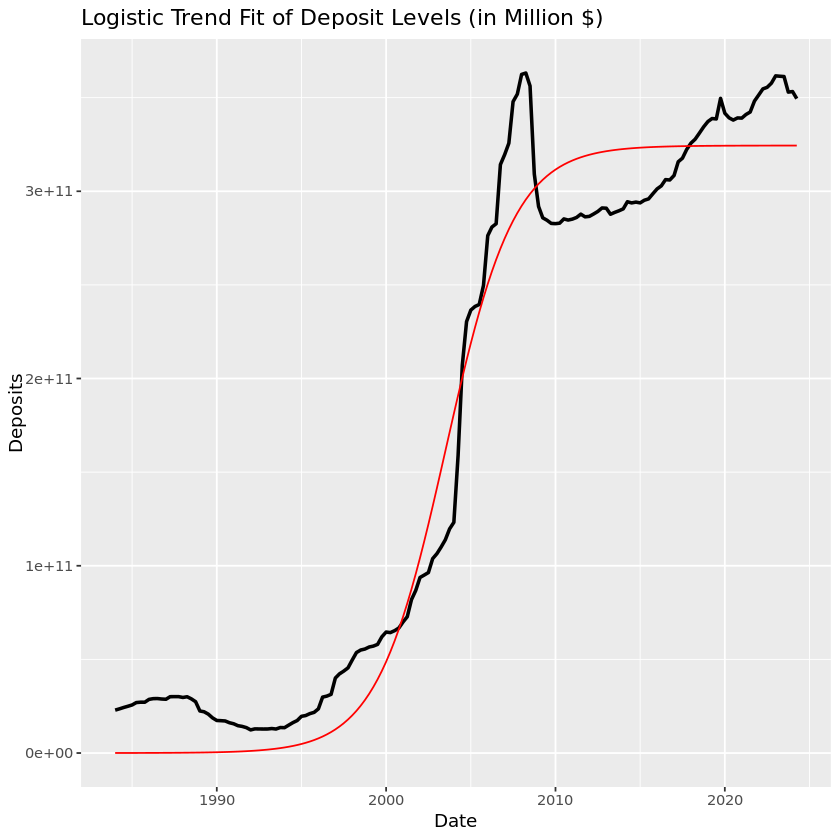

In [ ]:
# Step 1: Define a logistic function
logistic_function <- function(x, L, k, x0) {
  L / (1 + exp(-k * (x - x0)))  # L = carrying capacity, k = growth rate, x0 = midpoint
}

# Step 2: Fit the logistic model
logistic_model <- nls(deposits ~ logistic_function(time_as_numeric, L, k, x0),
                      data = deposit_levels,
                      start = list(L = max(deposit_levels$deposits), k = 0.01, x0 = median(deposit_levels$time_as_numeric)))


# Step 3: Add logistic trend predictions to the dataset
deposit_levels <- deposit_levels %>%
  mutate(logistic_trend = predict(logistic_model))

# Step 4: Plot the linear model
ggplot(deposit_levels, aes(x = time_as_date, y = deposits)) +
  geom_line(color = "black", linewidth = 1) +  # Actual data
  geom_line(aes(y = logistic_trend), color = "red") +  # Logistic trend
  labs(title = "Logistic Trend Fit of Deposit Levels (in $)", x = "Date", y = "Deposits") 

#### d. Conclusion for Trend

**Why NOT logistic trend model?**

- Even though, the logistic trend line seems to fit better past data, the logistic trend assumes market saturation and plateau. 
- But due to contextual information we have, we know that this is not a plateau but the slow growth was due to the 2008 crisis which is a one time event and not a recurring structural pattern.
- If we pick logistic trend, it might lead to under-predictions if the future involves a period of growth.
- This highlights the importance of blending data patterns with domain insights. A blind reliance on "best fit" could lead to a misinterpretation of the trends.

**Why pick linear trend fit?**
- Linear trends assume consistent growth over time, which aligns well with long-term economic expansion and deposit accumulation in a stable financial system
- Plus, current high interest rate environment incentivizes deposits.
- We see a continued economic recovery post 2008 crisis, suggesting deposits will grow, though slower than pre-crisis period.
- Uncertainty about inflation and the economy may drive precautionary savings since we are also recovering from the covid 19 crisis.
- Ultimately, choosing linear growth aligns with the economic rationale that deposits will likely grow as part of the recovery phase. 

**Additional Data Manipulation?**
- Will we have to use log? Or will that change the linearity?
- Applying a log transformation to your data can help make it fit better if your deposit levels grow exponentially rather than linearly. However, this doesn't change the fact that you're still modeling a linear trend—it just adjusts the scale to make it easier for Prophet to handle the data
- If your data already behaves linearly, logging may unnecessarily distort it. ==> I think it's fine


 


In [8]:
# Code to check for linearit assumption
linear_model1 <- lm(deposits ~ time_as_numeric, data = deposit_levels) # Linearity is struggling due to changepoints but I can add changepoints to prophet
#plot(linear_model1)
# Transform with log and see if it's better
linear_model2 <- lm(log(deposits) ~ time_as_numeric, data = deposit_levels) # No it did not help improve
#plot(linear_model2)


### Step 3: Seasonality Expectation

- Tools like Prophet and others can explicitly model seasonality if detected, which improves forecasting by capturing these periodic variations.

- However it's important to manually double check and understand the context behind the model.

- If seasonality exists but isn’t accounted for in the model, predictions may be inaccurate.

- For instance, if deposits consistently increase in Q4 but your model doesn’t include seasonality, it will underestimate future deposits in that quarter.

#### a. Let's plot a detrended ACF to check for seasonality

**How to read an ACF Plot**

- We look at the peaks that go above the blue line. Check lags based on the frequency:
   - Lag = 12 for monthly data (12 months in a year)
   - Lag = 4 for quarterly data
   - Lag = 52 for weekly data

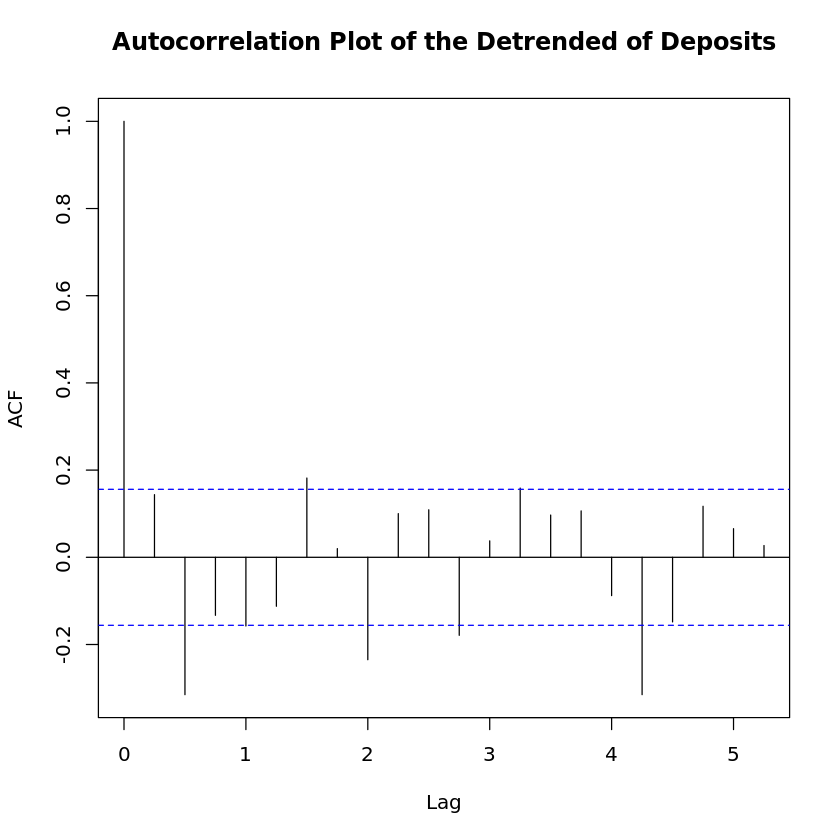

In [9]:
# Step 1: Convert deposits into a time series object. ACF only takes in time series data. 
deposit_time_series <- ts(deposit_levels$deposits, 
                        start = c(1984, 1), # we could have put deposit_levels$time_as_numeric but later on when plotting randomness the x axis won't show time properly so we just hardcode to tell where X axis will start and with frequency it knows how to link X and Y. 
                        frequency = 4) # Quarterly frequency 

# Step 2: Subtract the trend component, since the trend dominates, remove it to isolate the seasonality
        # Decompose the trend: breaks down the trend
deposit_decompose_trend <- decompose(deposit_time_series, type="additive") # breaks down dataset into 4 categories: observed data, trend, seasonality and randomness plot(deposit_decompose_trend) to see all 4 
        # Remove the trend from the time series data
deposit_detrended <- deposit_time_series - deposit_decompose_trend$trend

# Step 3: Plot ACF to check for seasonality
acf(deposit_detrended, na.action = na.omit, main = "Autocorrelation Plot of the Detrended of Deposits") # NAs comes from decomposition algorithm uses a moving window to calculate the trend, and it cannot compute values for the edges of the series.

#### b. Conclusion for Seasonality

- There are no peaks above the blue line at lag 4 (Quarterly Seasonality), the absence of such spikes suggests that quarterly seasonality is weak or not present in this case.

- For now, we will let Prophet's built-in seasonal detection handle any weak seasonal patterns

### Step 4: Outliers Expectation

**Why check for outliers**:  

- Prophet is designed to handle outliers and is fairly robust to their presence.

- However, extreme anomalies (like sudden, sharp increases or drops) can still affect the trend and seasonal components, distorting predictions.

In [10]:
# Check steps here: https://sqlpad.io/tutorial/interquartile-range/#:~:text=The%20standard%20method%20involves%20calculating,these%20bounds%20are%20potential%20outliers.

# Step 1: Calculate the IQR
IQR_value <- IQR(deposit_levels$deposits)

# Step 2: Define Boundaries
lower_bound <- quantile(deposit_levels$deposits, 0.25) - 1.5 * IQR_value
upper_bound <- quantile(deposit_levels$deposits, 0.75) + 1.5 * IQR_value

# Step 3: Flag Outliers
outliers <- subset(deposit_levels, deposits < lower_bound | deposits > upper_bound)

# step 4: Print Outliers
outliers

time,deposits,time_as_date,time_as_numeric,logistic_trend
<chr>,<dbl>,<date>,<dbl>,<dbl>



**Conclusion for Outliers:**

- Based of the results, it looks like the IQR method did not flag any outliers in the data. The deposit levels in the dataset fall within the acceptable range defined by the IQR method. The deposit levels may be naturally smooth without extreme spikes or dips (maybe lol?)

- Even without detected outliers, we should remain aware of contextual anomalies (e.g., the 2008 crisis) that could still affect model interpretation and trends.

### Step 5: Noise


**Why check for noise?**

- Noise refers to the unexplained or irrelevant variation in the data that cannot be attributed to meaningful patterns.
- Prophet is robust to noise, but excessive noise may require preprocessing (e.g., smoothing).
- A higher proportion (close to 1) indicates the data is dominated by noise.
- A lower proportion (closer to 0) means the data has more structured patterns (e.g., trend, seasonality).

In [11]:
# Calculate the variance of the residuals to quantify the noise and Compare this variance to the overall variance in the observed data.

# Variance of residuals (randomness)
residual_variance <- var(deposit_decompose_trend$random, na.rm = TRUE) # Use our decomposed dataset

# Variance of the original data
observed_variance <- var(deposit_time_series, na.rm = TRUE)  # Use our dataset that was transformed to time series, if we use deposit_levels directly it won't work

# Proportion of variance due to noise
global_noise_proportion <- residual_variance / observed_variance
global_noise_proportion

[1] 0.0006678225

**Conclusion for Noise**

- Our noise proportion of approximately 0.00067 (a very small number), which means: noise contributes very little to the overall variability in your data. 
- This is typical seen when our data has a strong long-term trend.
- So there won't be any need for excessive smoothing or denoising steps. Prophet can effectively handle the low-level noise.

#### Step 6: Localised Randomness

**Why check for randomness?**

-  Randomness, as shown in decomposition, includes localized irregularities or residual variations that aren't explained by the trend or seasonality but may include event-driven or one-off effects (like the 2008 crisis). It’s more localized and descriptive of specific periods rather than a global property like noise.
- While Prophet is robust to some noise, high randomness (localized irregularities) can make it harder to discern meaningful patterns.

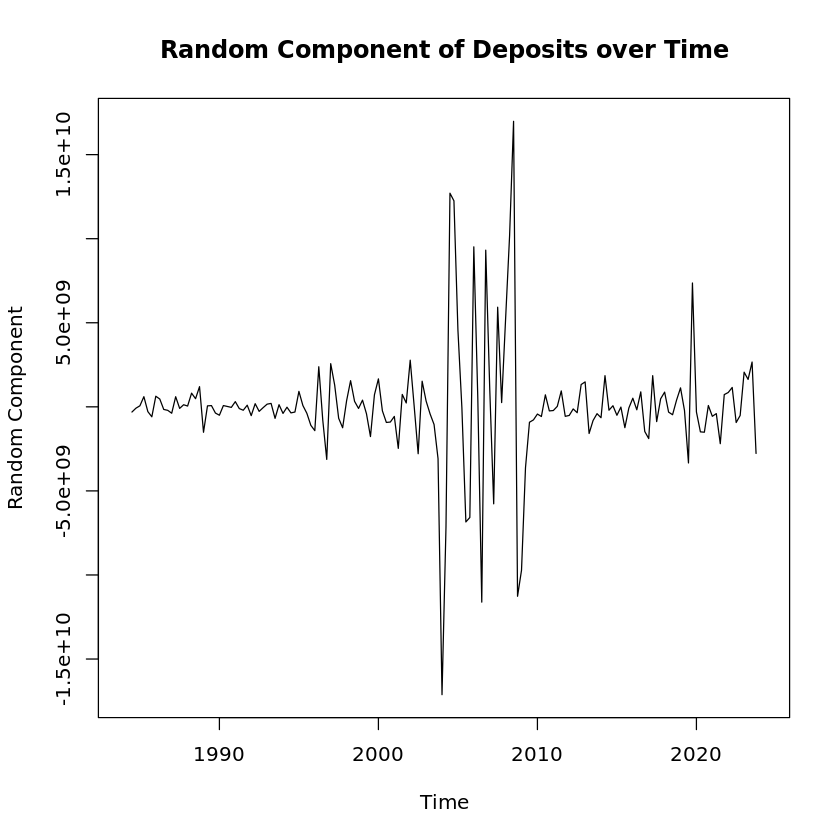

In [12]:
# plot(deposit_decompose_trend) ==> from the ACF code above in step 3.a

plot(deposit_decompose_trend$random,
    xlab = "Time",
    ylab = "Random Component",
    main = "Random Component of Deposits over Time")

**Conclusion for Randomness**
- There is significant randomness during the 2008 crisis period.
- We can add on a changepoint to handle abrupt trend changes.
- Prophet will automatically detects changepoints in the trend. However, you can manually specify changepoints (e.g., around 2008) where the data exhibits high variability.


## Part 3: Forecasting with Prophet

### Step 1: Split Data between training and test data

In [13]:
train_data <- deposit_levels[deposit_levels$time_as_date <= "2020-12-31", ]  # Training data: 1984 Q1 to 2020 Q4
test_data <- deposit_levels[deposit_levels$time_as_date > "2020-12-31", ]  # Testing data: 2021 Q1 to 2024 Q2

# Check
#View(train_data)
#View(test_data)


### Step 2: Prepared the Data

In [14]:
# Step 1: Prepare data for prophet to work

# you have to rename them as ds and y for prophet to work and it will automatically ignore all other columns ==> RULE
train_data$ds <- as.Date(train_data$time_as_date)
train_data$y <- train_data$deposits

test_data$ds <- as.Date(test_data$time_as_date)
test_data$y <- test_data$deposits

### Step 3: Fit Prophet on training data

In [15]:
# Step 1: Initialize the model
prophet_model<- prophet(changepoints = c("2008-01-01")) # Add Customizations based on assumptions made above https://stackoverflow.com/questions/64822488/how-to-use-prophets-make-future-dataframe-with-multiple-regressors
# We can later add on additional regressor to the best model

# Step 2: Fit the model: Training the model
prophet_model <- fit.prophet(prophet_model, train_data) # syntax


Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



Warning message in .local(object, ...):
“non-zero return code in optimizing”
Optimization terminated abnormally. Falling back to Newton optimizer.



### Step 4: Create a Future Dataframe

In [16]:
future_train_data <- make_future_dataframe(prophet_model, periods = 33, freq = "quarter") # start counting from the end of the training data: 2020 Q4 to 2028 Q1
#future_train_data # The output of make_future_dataframe() will include both the training data dates and the newly created future dates.

### Step 5: Predict Future Values

In [17]:
prediction_train_data <- predict(prophet_model, future_train_data)

### Step 6: Visualize the Forecast

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


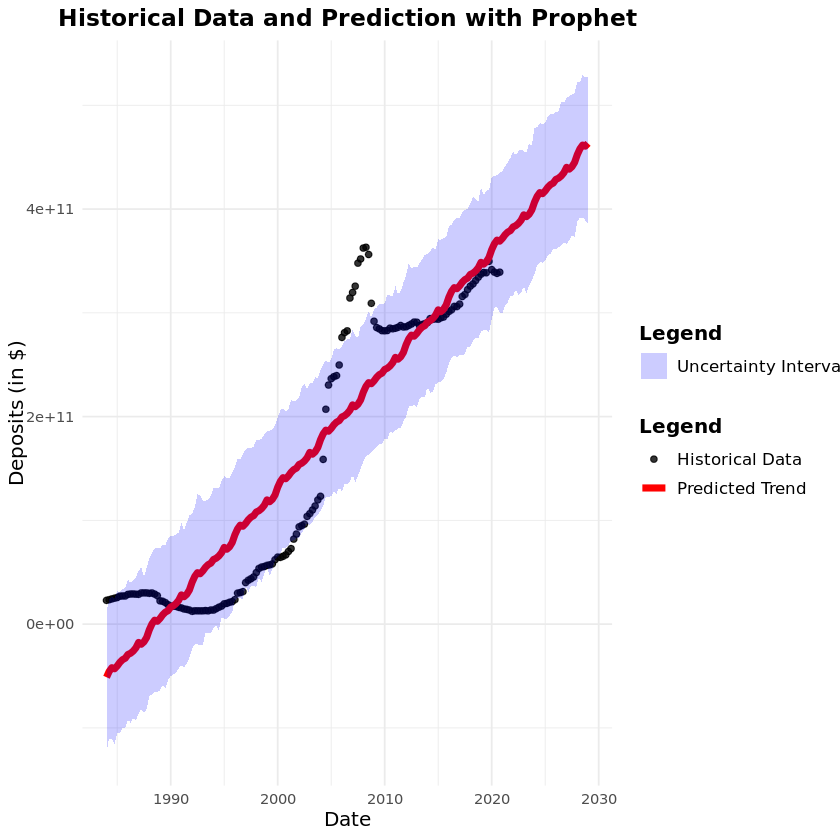

In [18]:
# Ensure 'ds' is a Date object
train_data$ds <- as.Date(train_data$ds)
prediction_train_data$ds <- as.Date(prediction_train_data$ds)

ggplot() +
  # Add historical data points
  geom_point(data = train_data, aes(x = ds, y = y, color = "Historical Data"), size = 1.5, alpha = 0.8) +
  # Add the predicted trend line
  geom_line(data = prediction_train_data, aes(x = ds, y = yhat, color = "Predicted Trend"), size = 2) +
  # Add uncertainty intervals for predictions
  geom_ribbon(
    data = prediction_train_data,
    aes(x = ds, ymin = yhat_lower, ymax = yhat_upper, fill = "Uncertainty Interval"),
    alpha = 0.2
  ) +
  # Add labels and a title
  labs(
    title = "Historical Data and Prediction with Prophet",
    x = "Date",
    y = "Deposits (in $)",
    color = "Legend",
    fill = "Legend"
  ) +
  # Customize colors for the legend
  scale_color_manual(
    values = c("Historical Data" = "black", "Predicted Trend" = "red")
  ) +
  scale_fill_manual(
    values = c("Uncertainty Interval" = "blue")
  ) +
  # Add a minimal theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 12),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10)
  )

## Part 4: Evaluation of the Model Performance

### Step 1: Compare predictions with test data 

- The test data is unseen data (not used in training) that allows you to assess how well your model generalizes to new data.
- Comparing predictions to actual values in the test data helps identify whether the model overfits or underfits.
- A good forecast should perform well not only on the training data but also on the test data. This is a crucial check before relying on the model for real-world forecasting.

In [19]:
#glimpse(test_data)

# Step 1: Create future dataframe for test data
future_test_data <- make_future_dataframe(prophet_model, periods = nrow(test_data), freq = "quarter") # Testing data: 2021 Q1 to 2024 Q2
#future_test_data

# Step 2: Make predictions for the test data
prediction_test_data <- predict(prophet_model, future_test_data) 
prediction_test_data$ds <- as.Date(prediction_test_data$ds) #make sure ds is in date format or else merge will fail

In [20]:
# Step 3: Merge predictions with actual test data: 
# The merging step combines your actual test data with the predictions generated by Prophet. This creates a single dataframe where you can directly compare the actual (y) and predicted (yhat) values for each time point (ds)
prediction_test_results <- merge(test_data, prediction_test_data[, c("ds", "yhat")], by = "ds")
prediction_test_results

#test_data
#prediction_test_data

ds,time,deposits,time_as_date,time_as_numeric,logistic_trend,y,yhat
<date>,<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01,2021Q1,339070926000,2021-01-01,18628,324359036936,339070926000,371764496914
2021-04-01,2021Q2,340991443000,2021-04-01,18718,324365839949,340991443000,375253433193
2021-07-01,2021Q3,342317919000,2021-07-01,18809,324371929301,342317919000,377808219919
2021-10-01,2021Q4,348156945000,2021-10-01,18901,324377371839,348156945000,379223672859
2022-01-01,2022Q1,351425943000,2022-01-01,18993,324382180069,351425943000,382796490012
2022-04-01,2022Q2,354666330000,2022-04-01,19083,324386341043,354666330000,383982465743
2022-07-01,2022Q3,355495449000,2022-07-01,19174,324390065459,355495449000,386106556777
2022-10-01,2022Q4,357699656000,2022-10-01,19266,324393394219,357699656000,389264027320
2023-01-01,2023Q1,361631019000,2023-01-01,19358,324396334988,361631019000,394422515288


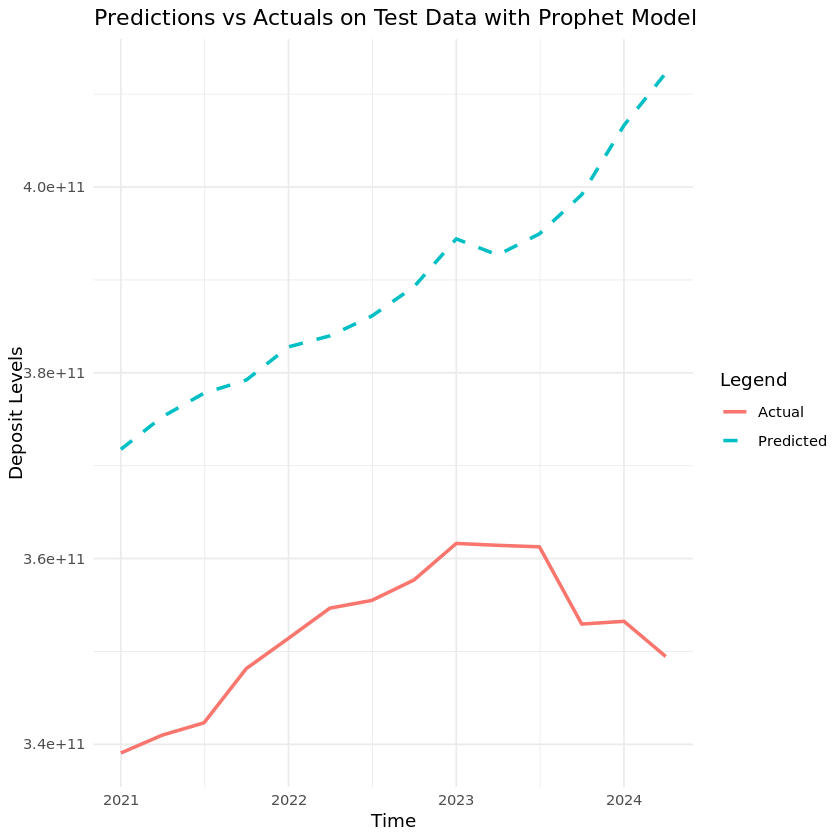

In [21]:
# Step 4: Plot the predictions vs actuals
ggplot(prediction_test_results, aes(x = ds)) +
  geom_line(aes(y = y, color = "Actual"), size = 1) + # Actual test data
  geom_line(aes(y = yhat, color = "Predicted"), size = 1, linetype = "dashed") + # Predictions
  labs(
    title = "Predictions vs Actuals on Test Data with Prophet Model",
    x = "Time",
    y = "Deposit Levels",
    color = "Legend"
  ) +
  theme_minimal()


**Observations**
- The predicted model (blue dashed line) done with Prophet does not closely align with the test (actual) data from 2021 to 2024. 
- There's a significant divergence between the actuals and predictions: the model overpredicts significantly in this range, showing an upward trend, whereas the actual values flatten or slightly decrease.

### Step 2. Compute Perfomance Metrics

- Necessary to be able to quantify the discrepancy between the actual data (test data) and the predicted data

In [22]:
# Mean Absolute Error (MAE)

actual <- prediction_test_results$y
predicted <- prediction_test_results$yhat

MAE_prophet <- mean(abs(actual - predicted))
MAE_prophet

# Root Mean Squared Error (RMSE)
RMSE_prophet <- sqrt(mean((actual - predicted)^2))
RMSE_prophet

# Mean Absolute Percentage Error (MAPE)
MAPE_prophet <- mean(abs(actual - predicted) / actual) * 100
MAPE_prophet

[1] 36897234426

[1] 38141270819

[1] 10.48863

- MAE = 36897, on average, our model's predictions are off by $36897 (Million) from the actual values.
- RMSE = 38141
- MAPE = 10%, on average our prediction are off by 10%. 

# Part 5: Adding on External Regressors to the Model

## Step 1: Select Relevant Features through domain knowledge

- Our goal here is research features that are likely to affect deposit level
- To narrow our options we will use a mix of domain knowledge and a LASSO regression to undertand the relationship between deposit and those potential regressors

> Here is a list of features through reserach and domain knowledge that I believe most impact deposit levels:
- GDP Growth Rate: Stronger economic growth can lead to higher income and savings
- Unemployment Rate: Higher unemployment can reduce deposits due to lower income
- Consumer Confidence Index: Reflects consumers' willingness to save vs. spend
- Population Growth: Larger populations in a region can increase deposit levels over time
- 10 Year Treasury Yield: Represent the interest rate environment, directly affecting deposit rates and competing as an alternative safe investment option.
- Federal Funds Effective Rate: impacts savings account interest rate
- Disposable Personal Income (percent change from year ago): ok
- Consumer Price Index (units: growth rate previos period in decimal): measure of inflation rate. Higher inflation may reduce disposable income and savings levels
- Average CD rates: (can't find)
- S&P 500: Reflects market sentiment and wealth effects, influencing whether people move funds into or out of savings accounts based on economic optimism or risk-taking behavior (hard find)

## Step 2: Narrow Down Features through LASSO Regression